In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.linalg import sqrtm
from sklearn.manifold import Isomap
from sklearn.datasets import make_blobs
from sklearn.feature_selection import mutual_info_classif

plt.rcParams['font.size'] = 32
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
font = {'size'   : 7}
plt.rc('font', **font)

In [103]:
D = 16 # observation dimension
P = 2 # latent variable space dimension

# read data from file
df = pd.read_csv('zoo.data', header=None)

Y = df.drop(columns=[0,17])
# centering and standardization
Y = Y - Y.mean(axis=0)
Y = Y/np.std(Y,axis=0)

names = df[0]
t = df[17]

# Compute information gain for each variable.
# This is the amount of information we gain about the response variable type
# from observing each regressor variable.
# We can see if this looks plausible by comparing with magnitudes of 
# correlation coefficents.

info_gain = mutual_info_classif(Y,t,discrete_features=True).reshape(16,1)

N = len(Y)
Y = Y.transpose().to_numpy()

In [104]:

# create weighted data vectors by the importance (information gain) of each feature
# this is equal to weighting the corresponding 
Y_weighted = np.multiply(info_gain**(1/2), Y)
Y_weighted = Y_weighted - Y_weighted.mean(axis=0)
Y_weighted = Y_weighted/np.std(Y_weighted,axis=0)


In [122]:
### Visualization

def plot_and_annotate(x1,x2,t=None, d=0.3, annotate_indices=False,annotate_names=False):
    '''Scatterplot with numbers at the side, in the order they were in the vector
    d controls how far from the point the text is'''
    fig, ax = plt.subplots(figsize=(12, 8))
    if t.any()==None:
        t=np.zeros_like(x1)
    ax.scatter(x1, x2, c=t, cmap='rainbow')
    plt.rc('font', size=7)
    plt.rc('figure', titlesize=14)
    for n in range(len(x1)):
        
        if annotate_indices:
            text=str(n)
        elif annotate_names:
            text=names[n]
        else:
            text=str(t[n])
        
        ax.annotate(text, (x1[n], x2[n]), (x1[n]+d, x2[n]-d), fontsize=10)
        
def double_centering(mat):
    '''performs double centering following (Lee&Verleysen 2007, p. 77)'''
    M,N = mat.shape
    assert M == N
    ones = np.ones((N,1))/np.sqrt(N)
    return -1/2*(mat-mat@ones@ones.T-ones@ones.T@mat+ones@ones.T@mat@ones@ones.T)

def dmatrix(Y):
    '''Computes squared distance matrix'''
    gram = Y.T@Y
    dist = np.zeros_like(gram)
    for i in range(gram.shape[0]):
        for j in range(gram.shape[1]):
            dist[i,j] = -2*gram[i,j] + gram[i,i] + gram[j,j]
            
    return dist
    

## PCA

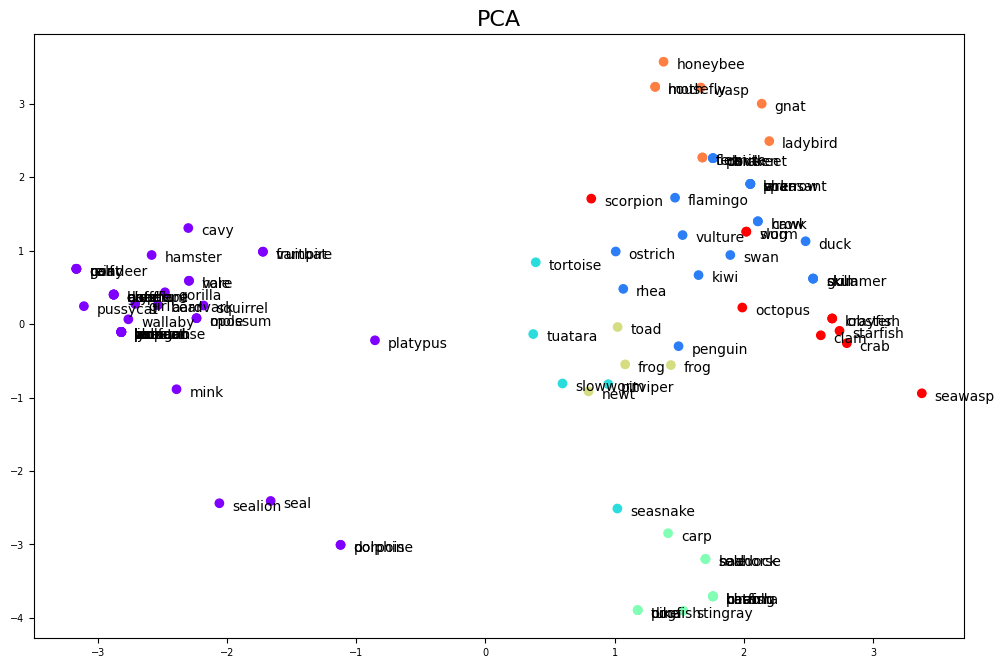

In [98]:
# SVD, and extract first P columns
u, _, _ = np.linalg.svd(Y, full_matrices=True, compute_uv=True, hermitian=False)
x_hat = np.eye(P,M=D)@u.T@Y

plot_and_annotate(x_hat[0], x_hat[1],t, d=0.1, annotate_names=True)
plt.title("PCA", fontsize=16)
#plt.savefig("plots/pca_easy.jpg")
plt.show()

## MDS

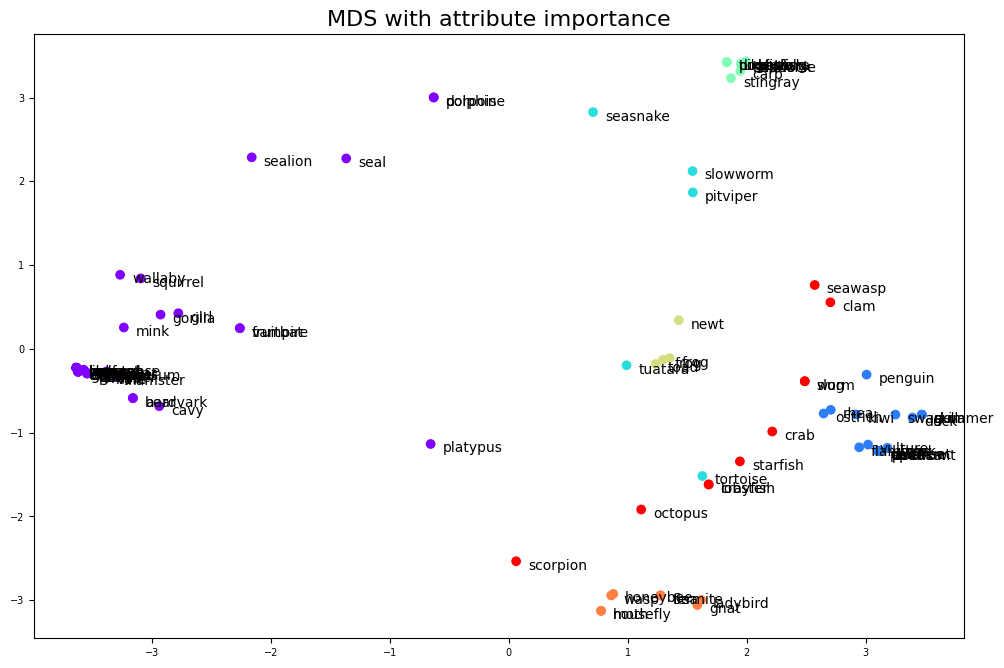

In [130]:
M1 = dmatrix(Y_weighted)
S1 = double_centering(M1)

lam, q = np.linalg.eig(S1)

x_hat = np.real(np.eye(P,M=N)@sqrtm(np.diag(lam))@q.T)
plot_and_annotate(-x_hat[0,:],x_hat[1,:],t,d=0.1,annotate_names=True)
plt.title("MDS with attribute importance", fontsize=16)
#plt.savefig("plots/mds_weighted_easy.jpg")
plt.show()

## Isomap

In [131]:
## Isomap implementation

from sklearn import neighbors    

def neighbors_only_edm(D, n_neighbors=5):
    # Returns euclidean distance matrix where only the 
    # n_neighbors nearest neighbors are nonzero
    N = len(D) #number of points
    G = np.zeros((N,N))
    for i in range(N):
        sorted_nbs = np.argsort(D[i][i+1:])
        close_pts = sorted_nbs[:n_neighbors]
        for j in close_pts:
            G[i,j+i+1] = 1
            G[j+i+1,i] = 1
            
    idx = np.where(G==1)
    D_nbs = np.full((N, N), np.inf)
    for i in range(len(idx[0])):
        D_nbs[idx[0][i],idx[1][i]] = D[idx[0][i],idx[1][i]]
    return D_nbs
    
def construct_graph(dists, neighs, n_neighbors):
    G = nx.Graph()
    n_pts = len(dists)
    G.add_nodes_from(np.arange(n_pts))
    G.add_weighted_edges_from(list(zip(neighs.flatten(),
                                       np.repeat(np.arange(n_pts), n_neighbors), 
                                       dists.flatten()))
    )
    return G

def D_geodesic(G):
    n_pts = G.number_of_nodes()
    D = np.full((n_pts,n_pts), np.inf)
    for i in range(n_pts):
        for j in range(n_pts):
            D[i][j] = nx.shortest_path_length(G, source=i, target=j)
            
    return D
    

def patch_graph(G,D):
    N = nx.number_connected_components(G)
    print("Number connected comp: "+str(N))
    components = [list(c) for c in nx.connected_components(G)]
    for i in range(N):
        for j in range(i+1,N): # i,j are component indices
            shortest = np.inf
            for i_pt in components[i]:
                for j_pt in components[j]:
                    if D[i_pt,j_pt] < shortest:
                        shortest = D[i_pt,j_pt]
                        u,v = i_pt,j_pt
            G.add_weighted_edges_from([(u,v,shortest)])
    return G

# Compute lengths
def isomap(Y, embedding_dim, n_neighbors):
    dist_matrix = dmatrix(Y)
    # compute k nearest neighbors for points
    ball_tree = neighbors.BallTree(Y.T)
    dists, neigh = ball_tree.query(Y.T, k=n_neighbors)
    # construct a graph out of nearest neighbors for each node
    G = construct_graph(dists, neigh, n_neighbors)
    # patch graph if disconnected at this point
    # D is the geodesic distance matrix along graph
    if nx.number_connected_components(G) > 1:
        D = D_geodesic(patch_graph(G,dist_matrix))
    else:
        D = D_geodesic(G)
        
    # mds method on this distance matrix
    gram = double_centering(D)
    sigma,u = np.linalg.eig(gram)
    return np.real(sqrtm(np.diag(sigma))@u.T)[:embedding_dim]
    

Number connected comp: 12


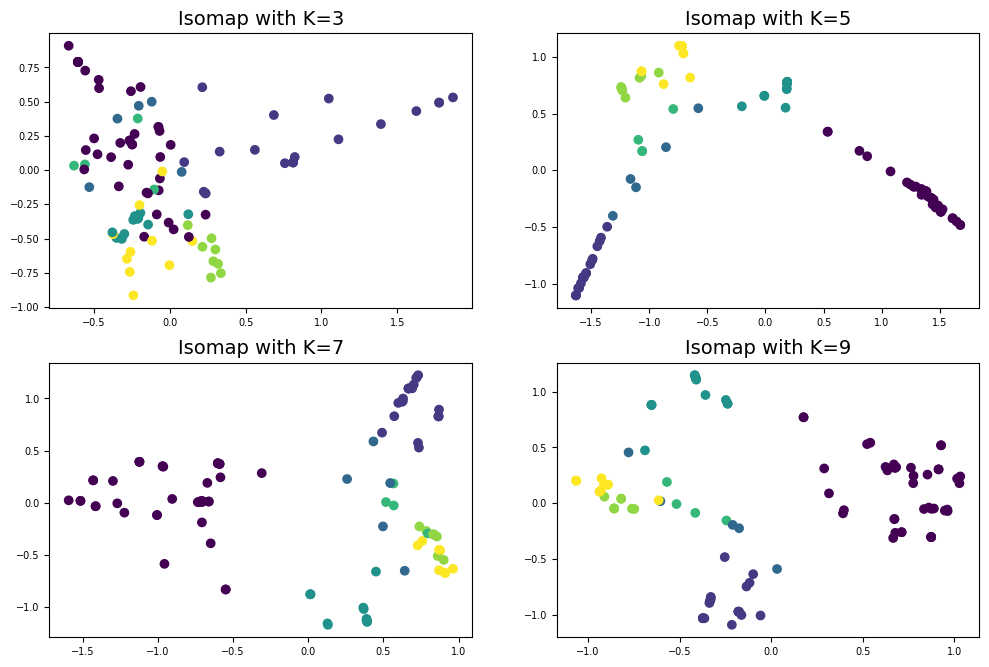

In [134]:
fig, axs = plt.subplots(2,2)
X_hat = isomap(Y, 2, 3)
axs[0,0].scatter(X_hat[0],X_hat[1],c=t)
X_hat = isomap(Y, 2, 5)
axs[0,1].scatter(X_hat[0],X_hat[1],c=t)
X_hat = isomap(Y, 2, 7)
axs[1,0].scatter(X_hat[0],X_hat[1],c=t)
X_hat = isomap(Y, 2, 9)
axs[1,1].scatter(X_hat[0],X_hat[1],c=t)
axs[0,0].set_title("Isomap with K=3", fontsize=14)
axs[0,1].set_title("Isomap with K=5", fontsize=14)
axs[1,0].set_title("Isomap with K=7", fontsize=14)
axs[1,1].set_title("Isomap with K=9", fontsize=14)
plt.savefig("plots/isomap_subplots.jpg")
plt.show()

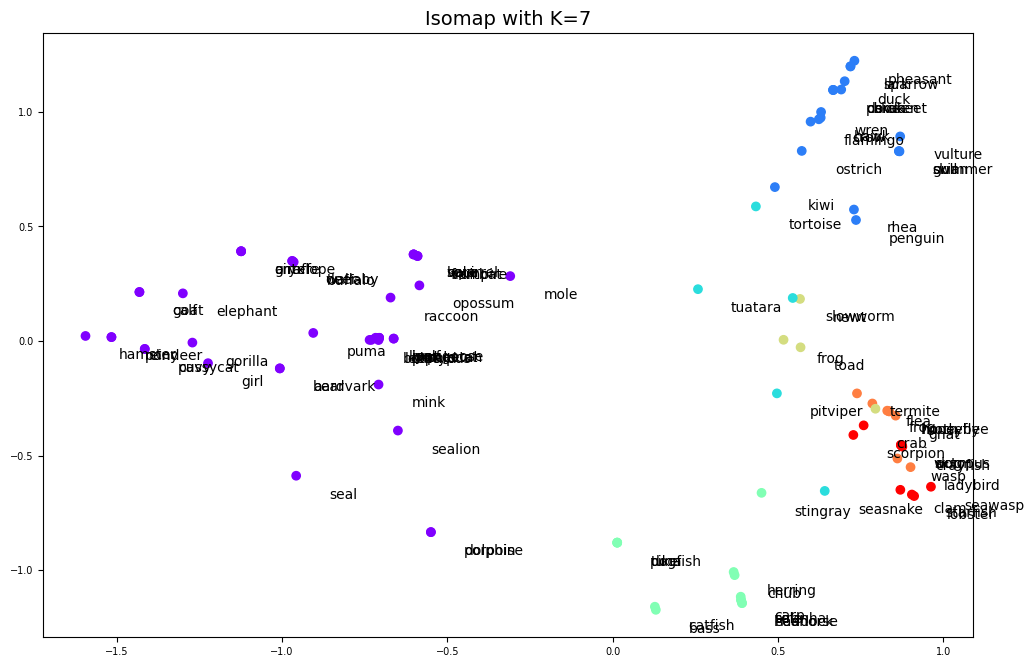

In [135]:
X_hat = isomap(Y, 2, 7)
plot_and_annotate(X_hat[0],X_hat[1],t,d=0.1,annotate_names=True)
plt.title("Isomap with K=7", fontsize=14)
plt.savefig("plots/isomap_7.jpg")
plt.show()